# 📌 Extraktion von Frames aus einem Video  

## 🔹 Übersicht  
Dieser Abschnitt beschreibt, wie **Einzelbilder (Frames) aus einem Video** extrahiert und als Bilddateien gespeichert werden.  
Die extrahierten Frames können für **Objekterkennung, Annotationen oder Trainingsdaten für ein YOLO-Modell** verwendet werden.  

---

## 🔹 Ablauf der Frame-Extraktion  
1. **Laden des Videos**  
   - Das Video wird mit **OpenCV (`cv2.VideoCapture`)** geöffnet.  
   - Falls das Video nicht geladen werden kann, wird eine Fehlermeldung ausgegeben.  

2. **Erstellung des Ausgabeordners**  
   - Falls der Zielordner für die Bilder nicht existiert, wird er automatisch erstellt.  

3. **Durchlaufen des Videos und Extraktion der Frames**  
   - Das Video wird **Frame für Frame** durchlaufen.  
   - Jeder Frame wird als **Bild (`.jpg`)** gespeichert.  
   - Der **Zeitstempel in Millisekunden** wird für die spätere Analyse mit in den Dateinamen geschrieben.  

4. **Speicherung der extrahierten Frames**  
   - Die Frames werden nach folgendem Namensschema gespeichert:  
     ```
     frame_<frame_nummer>_<timestamp>ms.jpg
     ```
     Beispiel:  
     ```
     frame_000010_333ms.jpg
     ```
   - Dies bedeutet, dass der **10. Frame bei 333ms (Millisekunden) im Video aufgenommen wurde**.  

---

## 🔹 Automatische Verarbeitung  
- Das Skript speichert alle extrahierten Frames im **Ordner `frames_output/`**.  
- Die Anzahl der gespeicherten Frames hängt von der Framerate des Videos ab (z. B. 30 FPS = 30 Bilder pro Sekunde).  

---

## 🔹 Beispielaufruf  
Falls das Video unter `C:\Python\ML Seminar\Seminararbeit WS24_25\Automated Machine Tending using a Universal UR5e cobot.mp4` gespeichert ist, wird die Funktion so ausgeführt:  

```python
video_datei = "C:\\Python\\ML Seminar\\Seminararbeit WS24_25\\Automated Machine Tending using a Universal UR5e cobot.mp4"
output_ordner = "frames_output"
extract_frames(video_datei, output_ordner)


In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder):
    # Video laden
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Fehler: Video konnte nicht geöffnet werden!")
        return
    
    # Ordner für Frames erstellen, falls nicht vorhanden
    os.makedirs(output_folder, exist_ok=True)
    
    frame_number = 0
    
    while True:
        success, frame = cap.read()
        if not success:
            break
        
        # Zeitstempel in Millisekunden berechnen
        timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
        
        # Bild speichern
        frame_filename = os.path.join(output_folder, f"frame_{frame_number:06d}_{timestamp_ms}ms.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_number += 1
    
    cap.release()
    print(f"Extraktion abgeschlossen. {frame_number} Frames gespeichert in '{output_folder}'")

# Beispielaufruf
video_datei = "C:\Python\ML Seminar\Seminararbeit WS24_25\Automated Machine Tending using a Universal UR5e cobot.mp4"  # Pfad zur Videodatei
output_ordner = "frames_output"  # Zielordner für die Bilder
extract_frames(video_datei, output_ordner)


# 📌 Konvertierung von LabelMe JSON zu YOLO TXT

## 🔹 Übersicht  
In diesem Abschnitt wird die Konvertierung von **LabelMe JSON-Annotationsdateien** in das **YOLO-Format** durchgeführt.  
YOLO benötigt Annotationen in `.txt`-Dateien mit einer spezifischen Struktur, die aus **Klassen-IDs und normalisierten Bounding-Box-Koordinaten** besteht.

---

## 🔹 Ablauf der Konvertierung  
1. **Einlesen der JSON-Dateien**:  
   - Die JSON-Dateien enthalten die Bounding-Box-Informationen aus **LabelMe**.  
   - Jede Annotation besteht aus einer Klasse und den Koordinaten der Bounding Box.  

2. **Umwandlung ins YOLO-Format**:  
   - Die Koordinaten werden **normalisiert** (Werte zwischen 0 und 1).  
   - Die Bounding Box wird als **(x_center, y_center, width, height)** gespeichert.  

3. **Speicherung der Ergebnisse**:  
   - Die erstellten `.txt`-Dateien werden im Ordner **`yolo_labels/`** gespeichert.  
   - Jede Datei entspricht einem Bild und enthält alle erkannten Objekte.  

---

## 🔹 Struktur der YOLO-Annotationsdatei  
Jede `.txt`-Datei hat das folgende Format:  


In [ ]:
import os
import json

# Pfade anpassen
json_folder = r"C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output"  # Ordner mit JSON-Dateien
output_folder = "yolo_labels"  # Zielordner für YOLO-Labels
os.makedirs(output_folder, exist_ok=True)

# Klassen-Mapping (muss mit deinen Labels übereinstimmen)
class_map = {"Werkzeug": 0, "Fräser": 1}  # Falls du mehr Klassen hast, erweitere es

def convert_labelme_to_yolo(json_path, output_path, img_width, img_height):
    """
    Konvertiert eine LabelMe JSON-Datei ins YOLO-Format.

    Parameter:
    - json_path (str): Pfad zur JSON-Datei mit Bounding-Box-Annotationen.
    - output_path (str): Pfad zur Ausgabe-TXT-Datei im YOLO-Format.
    - img_width (int): Breite des Bildes.
    - img_height (int): Höhe des Bildes.

    Beschreibung:
    - Liest die Bounding-Boxen aus der JSON-Datei.
    - Wandelt sie in das YOLO-Format um (normalisierte Werte).
    - Speichert das Ergebnis als TXT-Datei.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    yolo_labels = []
    for shape in data["shapes"]:
        label = shape["label"]
        if label not in class_map:
            continue  # Falls unbekannte Labels existieren, überspringen

        # Punkte der Bounding Box extrahieren
        x1, y1 = shape["points"][0]
        x2, y2 = shape["points"][1]

        # Bounding Box ins YOLO-Format umwandeln
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        width = abs(x2 - x1) / img_width
        height = abs(y2 - y1) / img_height

        yolo_labels.append(f"{class_map[label]} {x_center} {y_center} {width} {height}")

    # Speichere die YOLO-Annotationsdatei
    with open(output_path, "w") as f:
        f.write("\n".join(yolo_labels))

# Hauptprozess zur Verarbeitung aller JSON-Dateien
def process_json_files():
    """
    Durchläuft alle JSON-Dateien im angegebenen Ordner,
    liest die Bildgröße und konvertiert die Annotationen ins YOLO-Format.
    """
    for json_file in os.listdir(json_folder):
        if json_file.endswith(".json"):
            json_path = os.path.join(json_folder, json_file)
            txt_filename = json_file.replace(".json", ".txt")
            output_path = os.path.join(output_folder, txt_filename)

            # Lade die Bildgröße aus der JSON-Datei
            with open(json_path, "r") as f:
                data = json.load(f)
            img_width = data["imageWidth"]
            img_height = data["imageHeight"]

            # Umwandlung durchführen
            convert_labelme_to_yolo(json_path, output_path, img_width, img_height)

    print(f"Konvertierung abgeschlossen. Dateien gespeichert in '{output_folder}'.")

# Starte die Verarbeitung
process_json_files()


# 📌 Vorbereitung der YOLO-Trainingsdaten  

## 🔹 Übersicht  
In diesem Abschnitt werden die **gelabelten Bilder und JSON-Dateien** verarbeitet, um sie für das Training eines **YOLO-Modells** vorzubereiten.  
Die Annotationen werden von **LabelMe JSON** in das **YOLO TXT-Format** umgewandelt und anschließend in **Trainings- und Validierungssets** unterteilt.  

---

## 🔹 Ablauf der Datenverarbeitung  
1. **Definieren der Pfade & Klassen**  
   - Die Quelldaten (`.jpg` & `.json`) werden aus dem angegebenen Ordner geladen.  
   - Die Klassen werden einem numerischen Mapping (`class_map`) zugewiesen.  

2. **Erstellung der YOLO-Verzeichnisstruktur**  
   - Die folgenden Unterordner werden automatisch erstellt:  
     ```
     dataset/
     ├── images/
     │   ├── train/  # Trainingsbilder
     │   ├── val/    # Validierungsbilder
     │
     ├── labels/
     │   ├── train/  # Trainingslabels (YOLO TXT)
     │   ├── val/    # Validierungslabels (YOLO TXT)
     │
     └── data.yaml  # YOLO-Datensatzdefinition
     ```
     
3. **Konvertierung von LabelMe JSON zu YOLO TXT**  
   - Die Bounding-Box-Koordinaten aus den `.json`-Dateien werden eingelesen.  
   - Die Koordinaten werden normalisiert (`0-1` Skala) und als `.txt` gespeichert.  
   - Falls eine JSON-Datei ungültige Daten enthält, wird sie ignoriert.  

4. **Aufteilung in Training & Validierung**  
   - **80% der Bilder** werden für das Training, **20% für die Validierung** verwendet.  
   - Die zugehörigen `.txt`-Labeldateien werden in den entsprechenden Unterordner verschoben.  

5. **Erstellung der `data.yaml` Datei**  
   - Diese Datei ist erforderlich für YOLO und definiert die Trainings- und Validierungsdaten.  
   - Enthält die Anzahl der Klassen (`nc`) und deren Namen (`names`).  

---

## 🔹 Beispiel für eine YOLO `.txt`-Datei  
Jede `.txt`-Datei speichert die Annotationen für ein Bild:  


In [43]:
import os
import json
import shutil
import random

# **Pfad anpassen** (Quelldaten)
source_images = r"C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output"  # Bilder-Ordner
source_labels = r"C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output"  # JSON-Ordner
output_folder = r"C:\Python\ML Seminar\Seminararbeit WS24_25\dataset"  # Zielordner für YOLO-Format

# Setze den Seed für Reproduzierbarkeit
random.seed(42)

# **YOLO-Ordnerstruktur erstellen**
train_img_dir = os.path.join(output_folder, "images/train")
val_img_dir = os.path.join(output_folder, "images/val")
train_label_dir = os.path.join(output_folder, "labels/train")
val_label_dir = os.path.join(output_folder, "labels/val")

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# **Klassen-Mapping für YOLO**
class_map = {"Werkzeug": 0, "Fräser": 1}  # UTF-8 Korrektur für "Fräser"

def convert_labelme_to_yolo(json_path, output_txt_path, img_width, img_height):
    """ 
    Konvertiert eine LabelMe-JSON-Datei ins YOLO-Format und speichert alle Objekte.
    
    Parameter:
    - json_path (str): Pfad zur JSON-Datei mit den Bounding Boxen.
    - output_txt_path (str): Pfad zur Ausgabe-TXT-Datei im YOLO-Format.
    - img_width (int): Breite des Bildes.
    - img_height (int): Höhe des Bildes.

    Ablauf:
    - Liest die Bounding Boxen aus der JSON-Datei.
    - Konvertiert die Koordinaten in das YOLO-Format.
    - Speichert die Labels in einer `.txt`-Datei.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    yolo_labels = []
    print(f"📄 Verarbeite Datei: {json_path}")

    for shape in data["shapes"]:
        label = shape["label"]
        if label not in class_map:
            print(f"⚠ Warnung: Label '{label}' nicht in class_map! Datei wird ignoriert.")
            continue  # Unbekannte Labels überspringen

        if shape.get("shape_type") != "rectangle":
            print(f"❌ Fehler: '{label}' hat kein shape_type=rectangle! Datei wird ignoriert.")
            continue

        if len(shape["points"]) < 2:
            print(f"❌ Fehler: Bounding Box für '{label}' hat weniger als 2 Punkte! Datei wird ignoriert.")
            continue

        x1, y1 = shape["points"][0]
        x2, y2 = shape["points"][1]

        # **YOLO-Format (Mittelpunkt + Größe)**
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        width = abs(x2 - x1) / img_width
        height = abs(y2 - y1) / img_height

        yolo_labels.append(f"{class_map[label]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        print(f"✅ Bounding Box gespeichert: {yolo_labels[-1]}")

    # **Speichert alle Labels in die .txt-Datei**
    if yolo_labels:
        with open(output_txt_path, "w", encoding="utf-8") as f:
            f.write("\n".join(yolo_labels))
        print(f"✅ {len(yolo_labels)} Objekte gespeichert in: {output_txt_path}")
    else:
        print(f"⚠ Warnung: Keine gültigen Labels in {json_path}")

def process_json_to_yolo():
    """ 
    Durchläuft alle JSON-Dateien im Label-Ordner, konvertiert sie ins YOLO-Format 
    und speichert die Labels als `.txt`.
    """
    valid_images = []

    for json_file in os.listdir(source_labels):
        if json_file.endswith(".json"):
            json_path = os.path.join(source_labels, json_file)
            img_filename = json_file.replace(".json", ".jpg")  # Falls PNG oder JPEG, anpassen
            img_path = os.path.join(source_images, img_filename)

            if not os.path.exists(img_path):
                print(f"❌ Fehler: Kein passendes Bild für {json_file} gefunden! Überspringe...")
                continue  # Falls kein Bild existiert, überspringen

            txt_filename = json_file.replace(".json", ".txt")
            output_txt_path = os.path.join(source_labels, txt_filename)

            # **Bildgröße aus JSON lesen**
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            img_width = data["imageWidth"]
            img_height = data["imageHeight"]

            # **JSON in YOLO-TXT konvertieren**
            convert_labelme_to_yolo(json_path, output_txt_path, img_width, img_height)
            valid_images.append(img_filename)

    return valid_images

def split_data(valid_images):
    """
    Teilt die Bilder in Trainings- und Validierungssets auf (80/20-Split).
    
    Parameter:
    - valid_images (list): Liste der verarbeiteten Bilddateien.
    """
    random.shuffle(valid_images)
    split_idx = int(0.8 * len(valid_images))
    train_files = valid_images[:split_idx]
    val_files = valid_images[split_idx:]

    # **Bilder und Labels in `train/val` verschieben**
    for img in train_files:
        label = img.replace(img.split('.')[-1], "txt")
        shutil.copy(os.path.join(source_images, img), os.path.join(train_img_dir, img))
        shutil.copy(os.path.join(source_labels, label), os.path.join(train_label_dir, label))

    for img in val_files:
        label = img.replace(img.split('.')[-1], "txt")
        shutil.copy(os.path.join(source_images, img), os.path.join(val_img_dir, img))
        shutil.copy(os.path.join(source_labels, label), os.path.join(val_label_dir, label))

    print(f"✅ Datenset erstellt: {len(train_files)} Trainingsbilder, {len(val_files)} Validierungsbilder")

def create_data_yaml():
    """ 
    Erstellt die `data.yaml` Datei für das YOLO-Training.
    """
    data_yaml_content = f"""train: {output_folder}/images/train
val: {output_folder}/images/val
nc: {len(class_map)}
names: {list(class_map.keys())}
"""

    # Datei sicher schreiben
    data_yaml_path = os.path.join(output_folder, "data.yaml")
    with open(data_yaml_path, "w", encoding="utf-8") as f:
        f.write(data_yaml_content)

    print(f"✅ `data.yaml` wurde erfolgreich erstellt unter: {data_yaml_path}")

# **Workflow ausführen**
valid_images = process_json_to_yolo()
split_data(valid_images)
create_data_yaml()


📄 Verarbeite Datei: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000012_400ms.json
✅ Bounding Box gespeichert: 0 0.469758 0.507280 0.182712 0.269937
✅ 1 Objekte gespeichert in: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000012_400ms.txt
📄 Verarbeite Datei: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000013_433ms.json
✅ Bounding Box gespeichert: 0 0.466608 0.501680 0.172631 0.274418
✅ 1 Objekte gespeichert in: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000013_433ms.txt
📄 Verarbeite Datei: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000021_700ms.json
✅ Bounding Box gespeichert: 0 0.462828 0.508401 0.149950 0.254256
✅ 1 Objekte gespeichert in: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000021_700ms.txt
📄 Verarbeite Datei: C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000029_966ms.json
✅ Bounding Box gespeichert: 0 0.458102 0.502800 0.154360 0.252016
✅ 1 Obje

# 📌 YOLOv8 Training mit Transfer Learning  

## 🔹 Übersicht  
In diesem Abschnitt wird das **YOLOv8-Modell mit Transfer Learning trainiert**.  
Dabei wird ein **vortrainiertes YOLOv8 Nano-Modell (`yolov8n.pt`)** genutzt, das durch das neue Datenset weiter optimiert wird.  

---

## 🔹 Ablauf des YOLO-Trainings  
1. **Laden des vortrainierten YOLOv8-Modells**  
   - Das Modell `yolov8n.pt` dient als Ausgangspunkt.  
   - Dieses Modell wurde bereits auf dem COCO-Datensatz trainiert und bietet eine gute Basis.  

2. **Feinabstimmung mit Transfer Learning**  
   - Statt das gesamte Modell von Grund auf neu zu trainieren, werden nur die **letzten Layer angepasst**.  
   - Die **ersten 10 Layer werden eingefroren** (`freeze=10`), um Zeit und Rechenleistung zu sparen.  

3. **Definieren der Trainingsparameter**  
   - `epochs=100`: Mehr Epochen verbessern die Erkennung, erfordern aber mehr Rechenzeit.  
   - `imgsz=640`: Die Bildgröße bleibt bei **640x640** (YOLO-Standard).  
   - `batch=8`: Batch-Größe – kann je nach GPU-Speicher angepasst werden.  
   - `workers=4`: Anzahl der CPU-Threads für das schnellere Laden der Daten.  
   - `lr0=0.001`: Reduzierte Lernrate für bessere Stabilität beim Transfer Learning.  

4. **Start des Trainings**  
   - Das Modell wird mit den Trainingsdaten aus `data.yaml` trainiert.  
   - Während des Trainings wird die Erkennungsleistung kontinuierlich evaluiert.  

---

## 🔹 Vorteile des Transfer Learnings  
✅ **Schnellere Trainingszeit** durch Freezing der frühen Schichten  
✅ **Weniger Daten erforderlich** im Vergleich zu einem Training von Grund auf  
✅ **Bessere Genauigkeit** durch Anpassung an das spezifische Datenset  

---

## 🔹 Beispielaufruf  
Das Training wird mit folgendem Code gestartet:  
```python
train_yolo_model()


In [9]:
from ultralytics import YOLO

# **Vortrainiertes Modell laden**
model = YOLO("yolov8n.pt")  # Nutze YOLOv8 Nano als Basis

def train_yolo_model():
    """
    Startet das Training des YOLOv8-Modells mit Transfer Learning.

    Parameter:
    - data (str): Pfad zur `data.yaml`, die Trainings- und Validierungsdaten definiert.
    - epochs (int): Anzahl der Epochen für das Training (höhere Werte verbessern oft die Erkennung).
    - imgsz (int): Bildgröße in Pixeln (Standard: 640x640).
    - batch (int): Batch-Größe pro GPU-Iteration (abhängig vom verfügbaren Speicher).
    - workers (int): Anzahl der CPU-Threads für das Laden der Trainingsdaten.
    - lr0 (float): Anfangswert für die Lernrate (niedriger für Transfer Learning).
    - freeze (int): Anzahl der eingefrorenen Layer (verhindert Änderungen in den frühen Schichten).

    Beschreibung:
    - Nutzt ein vortrainiertes YOLOv8-Modell als Basis.
    - Optimiert nur die letzten Layer für das spezifische Training.
    - Reduziert die Rechenzeit durch Freezing der ersten Schichten.
    """
    model.train(
        data=r"C:\Python\ML Seminar\Seminararbeit WS24_25\dataset\data.yaml",  # Dein YOLO-Datensatz
        epochs=100,      # Mehr Epochen für bessere Ergebnisse
        imgsz=640,       # Gleiche Bildgröße wie beim Training
        batch=8,         # Falls GPU-Speicher begrenzt ist, reduziere auf 4
        workers=4,       # CPU-Beschleunigung für Daten-Loading
        lr0=0.001,       # Initiale Lernrate (kleiner als Standard für Transfer Learning)
        freeze=10        # **Freezt die ersten 10 Schichten** → Spart Rechenzeit!
    )

# **Training starten**
train_yolo_model()


Ultralytics 8.3.70  Python-3.11.11 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Python\ML Seminar\Seminararbeit WS24_25\dataset\data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning C:\Python\ML Seminar\Seminararbeit WS24_25\dataset\labels\train.cache... 54 images, 0 backgrounds, 0 co
val: Scanning C:\Python\ML Seminar\Seminararbeit WS24_25\dataset\labels\val.cache... 17 images, 0 backgrounds, 0 corrup

Plotting labels to runs\detect\train22\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      2.322      4.715      1.986         17        640: 100%|██████████| 7/7 [00:20<00:00,  2.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00411      0.382    0.00366    0.00169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.774      4.223      1.616         12        640: 100%|██████████| 7/7 [00:24<00:00,  3.50
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00449      0.721     0.0071    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G       1.53      3.377      1.404          7        640: 100%|██████████| 7/7 [00:22<00:00,  3.25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00421      0.875      0.165     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.527      2.496      1.344         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.98
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00371       0.75      0.448      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.422       2.55       1.31         20        640: 100%|██████████| 7/7 [00:20<00:00,  2.92
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00387      0.875      0.479      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.325       2.12       1.31         14        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21    0.00732        0.5      0.492       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.501      2.212      1.379         22        640: 100%|██████████| 7/7 [00:21<00:00,  3.12
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21          1      0.367      0.497      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.261      1.767      1.216         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21          1      0.453      0.494      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.239       1.74      1.276         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0


                   all         17         21      0.921      0.471       0.49      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.245      1.603      1.213         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.91      0.471      0.488      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.233      1.712      1.247         12        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.86      0.875      0.805       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.244      1.716      1.214         18        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.975      0.851      0.882      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.219      1.626      1.184         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.92      0.875       0.87      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G        1.2      1.612      1.255         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.92      0.875       0.87      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.151      1.433      1.172         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.908      0.875      0.901      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.173      1.489      1.203         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.943      0.852      0.937      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.215      1.432      1.234         16        640: 100%|██████████| 7/7 [00:21<00:00,  3.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.987       0.85      0.953      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.125        1.3      1.196         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.896      0.875      0.933      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.047      1.256      1.131          9        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.965      0.875       0.97      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.112       1.36      1.197         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.982      0.993      0.995      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.041      1.196      1.113         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.977      0.996      0.995      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G       1.18      1.259      1.192         18        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.977      0.996      0.995      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.112      1.277      1.122         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.972      0.985      0.995      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.034      1.222      1.131         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.997          1      0.995      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       1.09      1.199      1.136         19        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.957      0.992      0.995      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.033      1.216      1.099         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.929      0.993      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.124      1.218      1.177         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.983      0.999      0.995      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.071      1.159      1.174         20        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.97          1      0.995      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.055      1.084      1.083         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.99          1      0.995      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.068      1.142      1.156          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.99          1      0.995      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.021      1.067       1.07         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.957       0.99      0.995      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.107      1.113      1.151         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.928      0.966      0.995      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.065      1.121      1.212         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.951      0.988      0.995      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.026       1.19      1.085          9        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.969      0.989      0.995      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.008      1.056      1.066         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.997      0.986      0.995      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.9349      1.001      1.058         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21          1      0.976      0.995      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9985      1.046       1.08          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.966      0.985      0.995      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.9531       1.01      1.051         17        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.966      0.985      0.995      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.9127     0.8802     0.9956         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.954      0.994      0.995      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.8911     0.9437      1.031         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.951      0.994      0.995      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.9817      0.984      1.083          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.964      0.997      0.995      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9909     0.9485      1.078         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.968      0.999      0.995        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.8816      0.905      1.008         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.976      0.991      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.025      1.039      1.127         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.976      0.995      0.995      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9301     0.9022      1.077         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.968      0.998      0.995      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9756     0.9526      1.102         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.968      0.998      0.995      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      0.987     0.9782      1.073         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.962      0.999      0.995      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.8954     0.8741      1.034         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21       0.96          1      0.994      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.8956     0.8501      1.054         12        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.963          1      0.994      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9195     0.8598      1.057         18        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.965          1      0.994       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.8653     0.8223      1.011         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.973          1      0.995      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.8213     0.8437      1.054         17        640: 100%|██████████| 7/7 [00:20<00:00,  3.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.994      0.995      0.995      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9273     0.8828      1.084          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.992      0.991      0.995      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.9049     0.8053      1.039         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.992      0.991      0.995      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.9094     0.9189      1.048         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.995          1      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8697     0.8531      1.045         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986      0.997      0.995      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9033     0.8319      1.033         18        640: 100%|██████████| 7/7 [00:20<00:00,  2.96
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.976      0.997      0.995      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.9671     0.9209      1.119          9        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.967          1      0.995      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8825     0.8104      1.022         17        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.965          1      0.995      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8599     0.7993      1.036         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.964          1      0.995      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.9189      0.849      1.119         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.965          1      0.995      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.7958     0.8614      1.019          6        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.965          1      0.995      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8176     0.7695      1.013         14        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.967          1      0.995      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8492      0.795      1.043         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.976          1      0.995      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.9051      0.787      1.033         14        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.975          1      0.995      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.9365     0.9336      1.114         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.973          1      0.995      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.7989     0.7571      1.017         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.975          1      0.995      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G       0.86     0.7483      1.015         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21       0.98          1      0.995      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.7606     0.7322      1.012          9        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986          1      0.995      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8876     0.7475      1.029         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986          1      0.995      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.7225     0.7193     0.9423          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986          1      0.995       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.7896     0.7875      1.028          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.984          1      0.995      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.8407     0.7486      1.043         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.973          1      0.995      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.8271     0.6986      1.002         17        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.963          1      0.995      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7735     0.7246     0.9477         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21       0.98          1      0.995      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      0.793     0.6933     0.9538         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.983          1      0.995      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7788     0.6604     0.9651         19        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986          1      0.995      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7652     0.7285     0.9954         18        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.986          1      0.995      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7843     0.7366      1.009         15        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.989          1      0.995      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7507     0.6916     0.9953         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.997      0.997      0.995      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7925     0.7102     0.9775         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.995          1      0.995      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.8075     0.7299       1.03         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.991          1      0.995      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      0.721     0.6755          1          9        640: 100%|██████████| 7/7 [00:20<00:00,  2.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.994          1      0.995      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7489     0.6304     0.9619         17        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.994      0.997      0.995      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7443     0.6358     0.9496         14        640: 100%|██████████| 7/7 [00:20<00:00,  2.87
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.994      0.997      0.995      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.8118      0.705      1.015         11        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.994      0.997      0.995      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.8286     0.6692     0.9934         13        640: 100%|██████████| 7/7 [00:20<00:00,  2.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.995      0.999      0.995      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.7416     0.7037          1         10        640: 100%|██████████| 7/7 [00:20<00:00,  2.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.994      0.999      0.995      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7491     0.6567     0.9845         16        640: 100%|██████████| 7/7 [00:20<00:00,  2.91
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.995      0.999      0.995      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7031     0.6392     0.9311         14        640: 100%|██████████| 7/7 [00:20<00:00,  2.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.995          1      0.995      0.639


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      0.814     0.9038      1.024          6        640: 100%|██████████| 7/7 [00:19<00:00,  2.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         17         21      0.993      0.997      0.995      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.832     0.8899      1.024          6        640: 100%|██████████| 7/7 [00:19<00:00,  2.82
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.993      0.991      0.995      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.8382     0.8905      1.057          8        640: 100%|██████████| 7/7 [00:19<00:00,  2.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21       0.99      0.997      0.995      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.7961     0.7893      1.026          6        640: 100%|██████████| 7/7 [00:19<00:00,  2.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21       0.99      0.997      0.995      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.7893     0.8624     0.9796          6        640: 100%|██████████| 7/7 [00:19<00:00,  2.83
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.983          1      0.995       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.7421     0.7605     0.9624          6        640: 100%|██████████| 7/7 [00:20<00:00,  2.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.987      0.994      0.995       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.7118     0.7768     0.9617          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.988      0.995      0.995      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.6748     0.7872     0.9819          6        640: 100%|██████████| 7/7 [00:19<00:00,  2.85
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.987      0.997      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.7257     0.8219     0.9938          8        640: 100%|██████████| 7/7 [00:20<00:00,  2.86
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.987      0.996      0.995      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.7139     0.7974     0.9934          7        640: 100%|██████████| 7/7 [00:19<00:00,  2.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         17         21      0.985      0.997      0.995      0.561



100 epochs completed in 0.634 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics 8.3.70  Python-3.11.11 torch-2.6.0+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0


                   all         17         21      0.968      0.999      0.995        0.7
              Werkzeug         17         17      0.936          1      0.995      0.738
                Frser          4          4          1      0.998      0.995      0.662
Speed: 1.8ms preprocess, 94.6ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs\detect\train22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DD68B2D650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

# 📌 Objekterkennung mit dem trainierten YOLOv8-Modell  

## 🔹 Übersicht  
Dieser Abschnitt zeigt, wie das **trainierte YOLOv8-Modell** genutzt wird, um Objekte in einem Bild zu erkennen.  
Das Modell wurde zuvor trainiert und wird nun zur **Bildanalyse mit Bounding Boxes** verwendet.  

---

## 🔹 Ablauf der Objekterkennung  
1. **Laden des trainierten YOLOv8-Modells**  
   - Das Modell `best.pt` aus dem Training wird geladen.  
   - Dieses Modell enthält die optimierten Gewichte basierend auf den benutzerdefinierten Trainingsdaten.  

2. **Laden eines Testbildes**  
   - Ein einzelnes Bild wird aus dem Datensatz oder einem anderen Quellordner geladen.  
   - Das Bild enthält Objekte, die das Modell erkennen soll.  

3. **Durchführen der Vorhersage**  
   - Das Modell wird auf das Bild angewendet (`model.predict()`).  
   - Die erkannten Objekte werden mit Bounding Boxes dargestellt.  
   - Das **annotierte Bild wird gespeichert** und direkt angezeigt (`save=True, show=True`).  

---

## 🔹 Beispiel für eine Vorhersage  
Falls sich das trainierte Modell unter  
`C:\Python\ML Seminar\Seminararbeit WS24_25\runs\detect\train22\weights\best.pt` befindet,  
kann eine Objekterkennung auf einem Bild wie folgt gestartet werden:  

```python
results = model.predict(image_path, save=True, show=True)


In [10]:
from ultralytics import YOLO
import cv2

model = YOLO(r"C:\Python\ML Seminar\Seminararbeit WS24_25\runs\detect\train22\weights\best.pt")
image_path = r"C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000027_900ms.jpg"

results = model.predict(image_path, save=True, show=True)  # Speichert und zeigt das Bild mit Bounding Boxes



image 1/1 C:\Python\ML Seminar\Seminararbeit WS24_25\frames_output\frame_000027_900ms.jpg: 384x640 1 Werkzeug, 265.3ms
Speed: 11.0ms preprocess, 265.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict2


# 📌 Live-Objekterkennung in Videos mit YOLOv8  

## 🔹 Übersicht  
In diesem Abschnitt wird ein **trainiertes YOLOv8-Modell** verwendet, um Objekte in einem **Live-Video** zu erkennen und zu analysieren.  
Die erkannten Objekte werden mit **Bounding Boxes** visualisiert und ihre Positionen samt Zeitstempel in einer **CSV-Datei gespeichert**.  

---

## 🔹 Ablauf der Live-Analyse  
1. **Laden des trainierten YOLOv8-Modells**  
   - Das zuvor trainierte Modell (`best.pt`) wird geladen.  
   - Das Modell wurde für spezifische Objekte trainiert und erkennt diese im Video.  

2. **Öffnen des Videos & Initialisierung**  
   - Das Video wird mit **OpenCV (`cv2.VideoCapture`)** geöffnet.  
   - Es werden die **FPS, Bildgröße und Gesamtzahl der Frames** ausgelesen.  

3. **Durchführung der Objekterkennung**  
   - Das Video wird **Frame für Frame** analysiert.  
   - YOLO erkennt Objekte, zeichnet **Bounding Boxes** und zeigt die Wahrscheinlichkeit an.  
   - Ein OpenCV-Fenster visualisiert das Live-Ergebnis.  

4. **Speicherung der erkannten Objekte**  
   - Für jedes erkannte Objekt werden folgende Daten gespeichert:  
     - **Frame-Nummer**  
     - **Zeitstempel in Sekunden**  
     - **Objektklasse** (z. B. "Werkzeug", "Fräser")  
     - **Mittelpunkt-Koordinaten (X, Y)**  
   - Die gesammelten Daten werden in einem **Pandas DataFrame** gespeichert.  

5. **CSV-Datei exportieren**  
   - Nach der Analyse wird eine **CSV-Datei mit den erkannten Objekten und Positionen** gespeichert.  
   - Diese Datei kann später für **Datenanalysen oder Bewegungsstudien** genutzt werden.  

6. **Live-Visualisierung & Beenden der Analyse**  
   - Das OpenCV-Fenster zeigt das Video mit Bounding Boxes.  
   - Durch Drücken von **'q'** kann die Analyse beendet werden.  

---

## 🔹 Beispiel für CSV-Ausgabe  
Nach der Analyse enthält die Datei `object_detections.csv` folgende Struktur:  


In [41]:
import cv2
import pandas as pd
from ultralytics import YOLO

# **Trainiertes YOLO-Modell laden**
model = YOLO(r"C:\Python\ML Seminar\Seminararbeit WS24_25\runs\detect\train22\weights\best.pt")

# **Pfad zum Eingabe-Video**
video_path = r"C:\Python\ML Seminar\Seminararbeit WS24_25\Automated Machine Tending using a Universal UR5e cobot.mp4"
cap = cv2.VideoCapture(video_path)

# **Prüfen, ob das Video geöffnet wurde**
if not cap.isOpened():
    print("❌ Fehler: Konnte das Video nicht öffnen!")
    exit()

# **FPS & Gesamtanzahl der Frames auslesen**
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames pro Sekunde
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Frame-Breite
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Frame-Höhe
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Gesamtanzahl der Frames

print(f"📹 Video geladen: {frame_width}x{frame_height} @ {fps} FPS, {total_frames} Frames gesamt")

# **DataFrame für die Speicherung der Objektdaten**
df = pd.DataFrame(columns=["Frame", "Timestamp (s)", "Object", "X", "Y"])

# **Fenster für die Live-Analyse erstellen**
cv2.namedWindow("YOLO Live Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("YOLO Live Detection", 800, 600)  # Fenstergröße setzen

# **Live-Analyse starten**
frame_id = 0  # Zähler für Frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Video beendet oder Fehler beim Laden eines Frames.")
        break  # Ende des Videos

    # **Zeitstempel berechnen**
    timestamp = frame_id / fps  # Zeit in Sekunden

    # **YOLO auf Frame anwenden**
    results = model(frame)

    # **Datenliste für das aktuelle Frame**
    detected_objects = []

    # **Bounding Boxes in das Frame zeichnen & Daten speichern**
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding Box-Koordinaten
            x_center = (x1 + x2) // 2  # Mittelpunkt X
            y_center = (y1 + y2) // 2  # Mittelpunkt Y
            class_id = int(box.cls[0])  # Klassen-ID
            confidence = float(box.conf[0])  # Wahrscheinlichkeit
            label = model.names[class_id]  # Klassenname

            # **Bounding Box & Label zeichnen**
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # **Daten in die Liste speichern**
            detected_objects.append({"Frame": frame_id, "Timestamp (s)": timestamp, "Object": label, 
                                     "X": x_center, "Y": y_center})

    # **Falls Objekte erkannt wurden, in DataFrame speichern**
    if detected_objects:
        df = pd.concat([df, pd.DataFrame(detected_objects)], ignore_index=True)

    # **Frame im OpenCV-Fenster anzeigen**
    cv2.imshow("YOLO Live Detection", frame)

    # **Drücke 'q' zum Beenden**
    key = cv2.waitKey(1)
    if key == ord('q'):
        print("❌ Beende Live-Analyse...")
        break

    frame_id += 1  # Frame-Zähler erhöhen

# **CSV-Datei speichern**
csv_path = r"C:\Python\ML Seminar\Seminararbeit WS24_25\object_detections.csv"
df.to_csv(csv_path, index=False)
print(f"✅ CSV gespeichert unter: {csv_path}")

# **Ressourcen freigeben**
cap.release()
cv2.destroyAllWindows()


📹 Video geladen: 640x360 @ 30 FPS, 1603 Frames gesamt

0: 384x640 1 Werkzeug, 143.6ms
Speed: 9.0ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 103.7ms
Speed: 3.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



C:\Users\vi50jepi\AppData\Local\Temp\ipykernel_9280\3439981515.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(detected_objects)], ignore_index=True)


0: 384x640 1 Werkzeug, 123.7ms
Speed: 3.0ms preprocess, 123.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 102.7ms
Speed: 3.0ms preprocess, 102.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 107.7ms
Speed: 2.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 104.7ms
Speed: 3.0ms preprocess, 104.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 107.7ms
Speed: 2.0ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 105.7ms
Speed: 4.0ms preprocess, 105.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Werkzeug, 103.7ms
Speed: 3.0ms preprocess, 103.7ms inference, 1.0ms postproce

# 📌 Analyse der Objektbewegung & Stillstandserkennung  

## 🔹 Übersicht  
Dieser Abschnitt wertet die aus der YOLO-Objekterkennung gespeicherten Daten aus, um die **Bewegung und Stillstandszeiten von Objekten** zu visualisieren.  
Die Stillstandszeiten werden basierend auf einem **Vektorschwellwert für Bewegung** berechnet.  

---

## 🔹 Ablauf der Datenanalyse  
1. **Laden der YOLO-Daten aus CSV**  
   - Die Datei `object_detections.csv` enthält die erkannten Objekte mit X/Y-Koordinaten und Zeitstempeln.  
   - Die Daten werden mit **Pandas (`pd.read_csv`)** geladen.  

2. **Visualisierung der X- & Y-Positionen**  
   - Für jedes erkannte Objekt wird eine **X-Positions-Kurve** und eine **Y-Positions-Kurve** über die Zeit erstellt.  
   - Dadurch lassen sich Bewegungsmuster über die Zeit erkennen.  

3. **Berechnung der Stillstandszeiten**  
   - Die Bewegung eines Objekts wird als **Vektor ΔV = sqrt(Δx² + Δy²)** berechnet.  
   - Falls sich die Bewegung eines Objekts unter einem bestimmten **Schwellenwert (MOVEMENT_THRESHOLD)** befindet, wird dies als Stillstand gewertet.  
   - Die Stillstandszeit wird über die aufeinanderfolgenden Frames akkumuliert.  

4. **Ergebnisse ausgeben**  
   - Die Stillstandszeiten werden für jedes Objekt berechnet und ausgegeben.  
   - Die **gesamte Stillstandszeit aller Objekte** wird ebenfalls berechnet.  

---

## 🔹 Parameter für die Stillstandserkennung  
- **`MOVEMENT_THRESHOLD = 500`** → Falls sich das Objekt weniger als **500 Pixel** bewegt, wird dies als Stillstand gewertet.  
- **`FRAME_STEP = 10`** → Die Berechnung erfolgt nur auf jedem **10. Frame**, um Rauschen zu reduzieren.  

---

## 🔹 Beispiel für eine Konsolenausgabe  
Nach der Analyse gibt das Skript folgende Stillstandszeiten aus:  


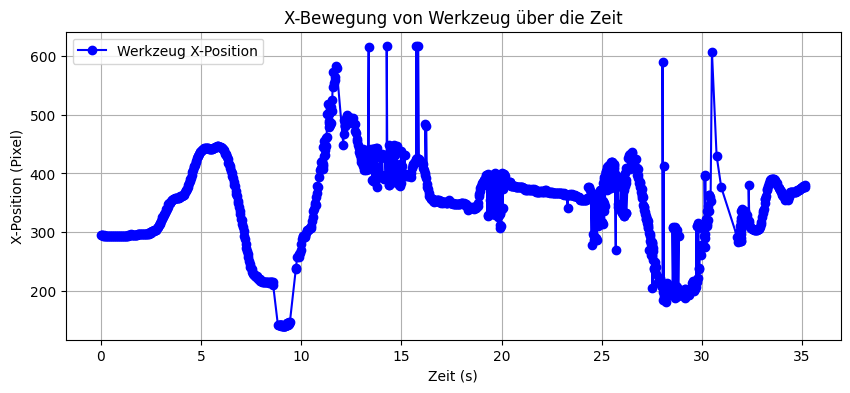

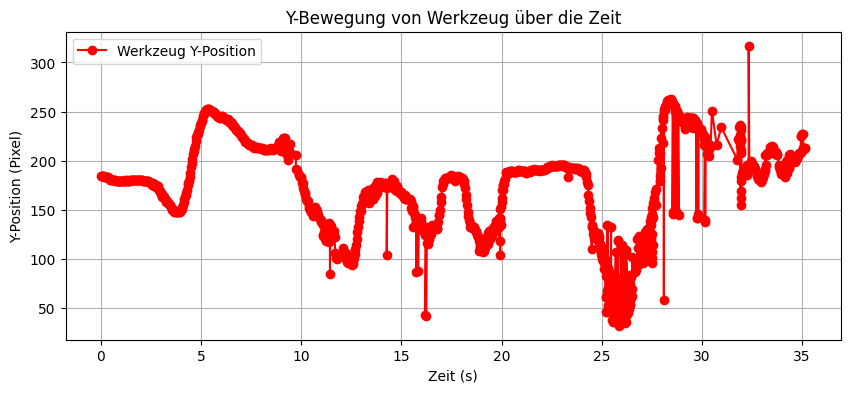

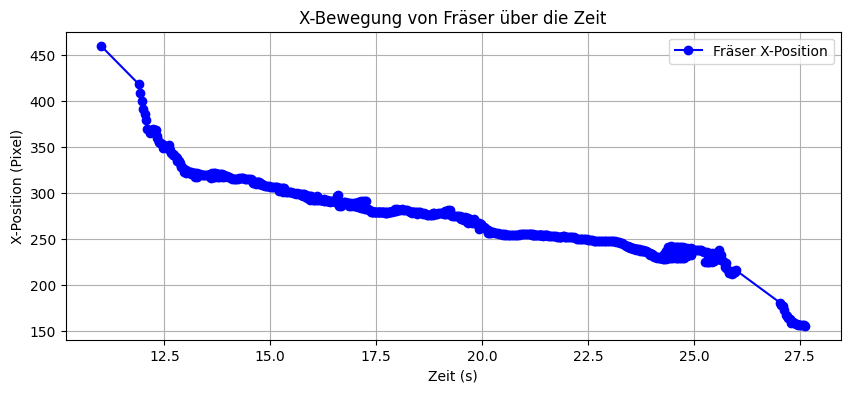

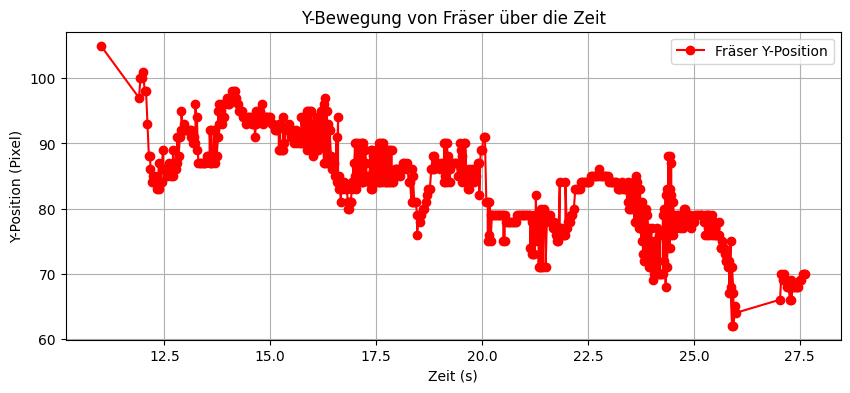


🛑 Stillstandszeiten pro Objekt (basierend auf Vektoren aus X- und Y-Änderung):
   → Werkzeug: 34.97 Sekunden
   → Fräser: 16.43 Sekunden

🔹 Gesamte Stillstandszeit: 51.40 Sekunden
   (Schwellenwert: 500 Pixel, Frame-Intervall: 10 Frames)


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# **CSV-Datei mit YOLO-Daten laden**
csv_path = r"C:\Python\ML Seminar\Seminararbeit WS24_25\object_detections.csv"
df = pd.read_csv(csv_path)

# **Parameter für Stillstandserkennung**
MOVEMENT_THRESHOLD = 500  # Euklidische Distanz (Pixel), unter der es als Stillstand zählt
FRAME_STEP = 10  # Nur jede X-te Frame wird betrachtet

# **Diagramme für X- und Y-Positionen jedes Objekts**
def plot_x_y_positions(df):
    objects = df["Object"].unique()

    for obj in objects:
        subset = df[df["Object"] == obj].sort_values("Timestamp (s)")

        # **X-Position vs. Zeit**
        plt.figure(figsize=(10, 4))
        plt.plot(subset["Timestamp (s)"], subset["X"], marker='o', linestyle='-', color='b', label=f"{obj} X-Position")
        plt.xlabel("Zeit (s)")
        plt.ylabel("X-Position (Pixel)")
        plt.title(f"X-Bewegung von {obj} über die Zeit")
        plt.legend()
        plt.grid()
        plt.show()

        # **Y-Position vs. Zeit**
        plt.figure(figsize=(10, 4))
        plt.plot(subset["Timestamp (s)"], subset["Y"], marker='o', linestyle='-', color='r', label=f"{obj} Y-Position")
        plt.xlabel("Zeit (s)")
        plt.ylabel("Y-Position (Pixel)")
        plt.title(f"Y-Bewegung von {obj} über die Zeit")
        plt.legend()
        plt.grid()
        plt.show()

# **Stillstandsberechnung basierend auf Vektoren aus X- und Y-Änderungen**
def calculate_stillstand_vector(df, movement_threshold, frame_step):
    stillstand_times = {}  # Dictionary zur Speicherung der Stillstandszeiten je Objekt

    for obj in df["Object"].unique():
        subset = df[df["Object"] == obj].sort_values("Frame")

        prev_x, prev_y, prev_time = None, None, None
        stillstand_duration = 0

        for i in range(0, len(subset), frame_step):  # Betrachte nur jede X-te Zeile (Frame-Step)
            row = subset.iloc[i]

            if prev_x is not None:
                # **Euklidische Distanz ΔV = sqrt(Δx² + Δy²)**
                delta_x = row["X"] - prev_x
                delta_y = row["Y"] - prev_y
                movement_vector = np.sqrt(delta_x**2 + delta_y**2)

                if movement_vector < movement_threshold:  # Falls Bewegung unter Schwellwert → Stillstand
                    stillstand_duration += (row["Timestamp (s)"] - prev_time)

            prev_x, prev_y, prev_time = row["X"], row["Y"], row["Timestamp (s)"]

        stillstand_times[obj] = stillstand_duration  # Speichere Stillstandszeit für dieses Objekt

    return stillstand_times

# **Diagramme für jedes Objekt anzeigen**
plot_x_y_positions(df)

# **Stillstandszeiten pro Objekt berechnen**
stillstand_times = calculate_stillstand_vector(df, MOVEMENT_THRESHOLD, FRAME_STEP)

# **Ergebnisse ausgeben**
print("\n🛑 Stillstandszeiten pro Objekt (basierend auf Vektoren aus X- und Y-Änderung):")
for obj, duration in stillstand_times.items():
    print(f"   → {obj}: {duration:.2f} Sekunden")

total_stillstand = sum(stillstand_times.values())  # Gesamtstillstandszeit berechnen
print(f"\n🔹 Gesamte Stillstandszeit: {total_stillstand:.2f} Sekunden")
print(f"   (Schwellenwert: {MOVEMENT_THRESHOLD} Pixel, Frame-Intervall: {FRAME_STEP} Frames)")
